In [149]:
import numpy as np
np.random.seed(1)
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from keras.models import Model,Sequential,save_model,load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation,BatchNormalization
from sklearn.model_selection import train_test_split

# ===================================================================================
# Data loading part
# ===================================================================================
def all_stock_name():
    filenames = os.listdir(path)
    temp = [filename for filename in filenames if filename.endswith('.csv')]
    # print temp
    return [x.replace('.csv', '') for x in temp]

def single_stock_data(stock_name):
    data_path = os.path.join(path, stock_name + '.csv')
    df = pd.DataFrame.from_csv(data_path, header=None, parse_dates=[[0, 1]])
    df.columns = ['Open', 'High', 'Low', 'Close', 'Outstanding', 'Turnover']
    # header=['date','time','open','high','low','close','outstanding','turnover']
    return df
  
def get_file_from_csv(data_path):
    df = pd.DataFrame.from_csv(data_path, header=None, parse_dates=[[0, 1]])
    df.columns = ['Open', 'High', 'Low', 'Close', 'Outstanding', 'Turnover']
    # header=['date','time','open','high','low','close','outstanding','turnover']
    return df

def divide_data(X,Y):
    return train_test_split(X, Y,test_size = 0.05, random_state = 42)



def norm_ts(Z):
    Z_norm = (Z - Z.min()) / (Z.max() - Z.min())
    invert_func = lambda X: (Z.max() - Z.min())*X + Z.min()
    return Z_norm,invert_func


def one_step_predict(model,train_features, train_labels):
    model.fit(train_features, train_labels, epochs=1, batch_size=64, shuffle=True)
    return model

# ===================================================================================
# Visualization the model
# ===================================================================================
def animation_train_and_test(train_labels, test_labels, predict_spread_1, predict_spread_2):
    # Configure the training plot
    fig = plt.figure()
    axes1 = fig.add_subplot(121)
    axes2 = fig.add_subplot(122)
    line, = axes1.plot(train_labels, np.zeros(train_labels.shape), 'ro')
    axes1.set_title('High Price')
    axes1.set_xlabel('Actual')
    axes1.set_ylabel('Model')
    line2, = axes2.plot(test_labels, np.zeros(test_labels.shape), 'bo')
    axes2.set_title('Low Price')
    axes2.set_xlabel('Actual')
    axes2.set_ylabel('Model')
    axes1.set_ylim([0, 1])
    axes2.set_ylim([0, 1])

    def corr_plt(data):
        line.set_ydata(data)
        return line,

    def corr_plt2(data):
        line2.set_ydata(data)
        return line2,

    ani = animation.FuncAnimation(fig, corr_plt, predict_spread_1, interval=1000)
    ani2 = animation.FuncAnimation(fig, corr_plt2, predict_spread_2, interval=1000)
    plt.show()


def very_simple_benchmark_model(X):
    daytimes = X.shape[1]
    x2 = np.linspace(0, daytimes - 1, num=daytimes)
    out = np.zeros((X.shape[0],1))
    for s in range(X.shape[0]):
        y1 = X[s,:,0]
        z = np.polyfit(x2, y1, 2)
        f = np.poly1d(z)
        out[s, 0] = f(daytimes)
    return out

  

In [150]:
#from google.colab import files
#uploaded = files.upload()

In [214]:
from keras.optimizers import adam
import random

path = r"C:\working\data_2012_07_2012_12\data\SH600036.csv"
df = get_file_from_csv(path)
dev_set = 20000
# random time
time_list = df.index.tolist()
lookback = 20
timewindow = 30
indices = random.sample(range(lookback+1, len(time_list)-timewindow), dev_set)


C:\working\ML_Python\Python3\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


In [216]:
# ===================================================================================
# Generate x and y
# ===================================================================================
def x_y_new(df,indices,outlier_prob=0.5,time_window =60,lookback = 55):
    M = len(indices)
    N = time_window +1
    # add time demension
    X = np.zeros((M, N, 2, 1))
    Y = np.zeros((M))
    
    
    # get the close price from the df
    raw_Z = np.zeros((len(df),7))
    raw_Z[:,0:6] = df.values
    raw_Z[:,6] = [x.value for x in df.index]
    
    norm_Z,invert_func = norm_ts(raw_Z[:,3])
    
    # generate trades
    for i in range(M):
        
      # take a snapshot from the original time series around the trading time
      z_local = norm_Z[indices[i] - lookback : indices[i] - lookback + time_window ]
        
      # create a two line array, one is benchmark trade line, one is actual trade line.
      # the only differences between the two line is the point on actual tradeing time
      # the benchmark line is average between last and next trades, the actual trade line is the actual price
      local_x = np.zeros((N,2,1))
      
      # firstly we create a benchmark trades line, the benchmark trades line contain all normal trades
      # and the price on trading time is calculated by average of the two
      local_x[0:lookback,0,0] = z_local[0:lookback]
      local_x[lookback+1:,0,0] = z_local[lookback:]
      local_x[lookback,0,0] = (z_local[lookback-1] + z_local[lookback])/2.0
    
      # then we generate the actual trade line
      local_x[:,1,0] = local_x[:,0,0]
      reasonable_range = local_x[lookback-5:lookback+3,0,0]
      min_reasonable = min(reasonable_range)
      max_reasonable = max(reasonable_range)
      temp = random.random()
      if temp > 0.5:
        trade_price = random.random()*(max_reasonable - min_reasonable) + min_reasonable
        Y[i] = 0.0
      elif temp > 0.25:
        trade_price = random.random()*(max_reasonable - min_reasonable) + max_reasonable
        Y[i] = 1.0
      else:
        trade_price = -random.random()*(max_reasonable - min_reasonable) + min_reasonable
        Y[i] = 1.0
      local_x[lookback,1,0] = trade_price
      
      local_x,_ = norm_ts(local_x)
        
        
      X[i,:,:,:] = local_x  
    return X,Y


In [217]:
X,Y = x_y_new(df,indices,lookback = lookback,time_window = timewindow)

print(X.shape)

(20000, 31, 2, 1)


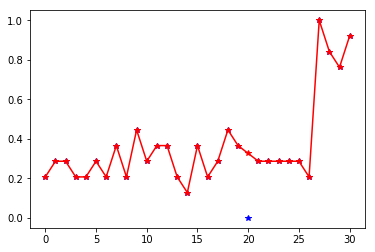

1.0


In [218]:
import matplotlib.pyplot as plt
idx = 1453
plt.plot(X[idx,:,1,0],'b*' )
plt.plot(X[idx,:,0,0],'r*-' )
plt.show()
print(Y[idx])

In [219]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D


# Loading the data (signs)
X_train,  X_test, Y_train_orig,Y_test_orig= divide_data(X,Y)



# Convert class vectors to binary class matrices.
num_classes = 2
Y_train = keras.utils.to_categorical(Y_train_orig.T, num_classes)
Y_test = keras.utils.to_categorical(Y_test_orig.T, num_classes)


print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))


number of training examples = 19000
number of test examples = 1000
X_train shape: (19000, 31, 2, 1)
Y_train shape: (19000, 2)
X_test shape: (1000, 31, 2, 1)
Y_test shape: (1000, 2)


In [220]:
model = Sequential()

model.add(Conv2D(48, (4, 4),padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(16, (4, 4),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4),padding='same'))
model.add(Conv2D(16, (4, 4),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4),padding='same'))
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [221]:

opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


model.summary()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


model.fit(X_train, Y_train,
              batch_size=100,
              epochs=100,
              validation_data=(X_test, Y_test),
              shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 31, 2, 48)         816       
_________________________________________________________________
activation_67 (Activation)   (None, 31, 2, 48)         0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 16, 1, 48)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 1, 16)         12304     
_________________________________________________________________
activation_68 (Activation)   (None, 16, 1, 16)         0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 4, 1, 16)          0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 4, 1, 16)          4112      
__________

19000/19000 [==============================] - 4s 200us/step - loss: 0.2771 - acc: 0.8815 - val_loss: 0.2778 - val_acc: 0.8820
Epoch 46/100
19000/19000 [==============================] - 4s 198us/step - loss: 0.2751 - acc: 0.8823 - val_loss: 0.2834 - val_acc: 0.8830
Epoch 47/100
19000/19000 [==============================] - 4s 201us/step - loss: 0.2740 - acc: 0.8829 - val_loss: 0.2760 - val_acc: 0.8800
Epoch 48/100
19000/19000 [==============================] - 4s 201us/step - loss: 0.2714 - acc: 0.8843 - val_loss: 0.2749 - val_acc: 0.8760
Epoch 49/100
19000/19000 [==============================] - 4s 200us/step - loss: 0.2705 - acc: 0.8834 - val_loss: 0.2818 - val_acc: 0.8770
Epoch 50/100
19000/19000 [==============================] - 4s 199us/step - loss: 0.2715 - acc: 0.8855 - val_loss: 0.2696 - val_acc: 0.8810
Epoch 51/100
19000/19000 [==============================] - 4s 199us/step - loss: 0.2676 - acc: 0.8835 - val_loss: 0.2682 - val_acc: 0.8820
Epoch 52/100
19000/19000 [=======

In [223]:
model.predict(X_test)

array([[9.9694061e-01, 3.0593653e-03],
       [6.9098252e-01, 3.0901751e-01],
       [6.7956018e-01, 3.2043979e-01],
       ...,
       [2.8659301e-04, 9.9971336e-01],
       [2.6289956e-03, 9.9737096e-01],
       [2.8808215e-01, 7.1191788e-01]], dtype=float32)

In [224]:
print(Y_test)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [226]:
model.save(r"C:\working\innovation_group\cnn_model\final_model.h5")